Mar 2023, Reworked this notebook, it does the following:
1.) Takes your sequence map (2D graph) and detects clusters in it, assuming you already have optimized clustering parameters(!)
If you do not have optimized clustering parameters, run the scout notebook
2.) Takes the detected clusters and created weblogos from all clusters
3.) It also outputs the consensus sequence and centroid sequence(s) from each cluster

# Import modules, inputs, outputs, parse input data

In [3]:
import Methods_Detect_and_Logo as methods

import os
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import pandas as pd
import random
import xlsxwriter

### Inputs, Output folder, Analysis Parameters

In [4]:
# Inputs
file_name = 'UMAP NGrams.csv'
save_title = f'{file_name[:-4]} FixLM'
filein = os.path.join(os.getcwd(),file_name)
print(filein)

# Analysis parameters, these should be scanned for
modelname = 'DBSCAN' # either AggCl for Agglomerative clustering or DBSCAN
epsy = 0.1022        # used in DBSCAN
sampley = 16         # used in both DBSCAN and Agglomerative clustering
consensus_cutoff = 0.5     # An amino acid must be present in x% or greater of cluster sequences to be consensus, otherwise X
Deconvolute_N_Grams = True  # Only use for N-grams analysis in the Logo plot section, uses ClustalW 2.1 for alignment deconvolution
NGRAM_MAX = 12

# Define dataset
print('Processing inputs')
df1 = pd.read_csv(file_name)
rep_red_name = save_title
# rep_red_name = 'UMAP Fingerprint' # use this if the filename does not match the dimensionality reduction, encoding method used

# Grab the C1 and C2 names and then the data
all_column_list = df1.columns.to_list()
C1_col_name = [s for s in all_column_list if 'C1' in s][0]
C2_col_name = [s for s in all_column_list if 'C2' in s][0]
X = np.asarray([(float(x), float(y)) for x, y in zip(df1[C1_col_name], df1[C2_col_name])])
print('Extracted data')

# Outputs
outputfile = os.path.join(os.getcwd(),'Outputs',save_title)
print(outputfile)
if not os.path.exists(outputfile):
    os.makedirs(outputfile)

C:\Users\josep\Documents\MIT\Machine Learning + Python\Binder Finder\20230325 - Seeing if Logomaker can be fixed\UMAP NGrams.csv
Processing inputs
Extracted data
C:\Users\josep\Documents\MIT\Machine Learning + Python\Binder Finder\20230325 - Seeing if Logomaker can be fixed\Outputs\UMAP NGrams FixLM


# Cluster detection model, parameters above

In [5]:
if modelname == 'DBSCAN':
    model = DBSCAN(eps=epsy, min_samples=sampley) # define the model
    print(f'DBSCAN detection, eps is {str(epsy)}, sample_min {str(sampley)}')

if modelname == 'AggCl':
    model = AgglomerativeClustering(n_clusters=sampley) # define the model
    print(f'AggCl detection, n_clusters is {str(sampley)}')
    epsy = ''

yhat = model.fit_predict(X) # fit model, predict clusters. Every row has a cluster associated.
yhat = yhat + 1 # This is done because clusters start at 0, and we want to label them starting at 1.
# Note that for DBSCAN now the -1th cluster is noise, with this re-labeling cluster 0 is noise.
# For both DBSCAN and Agglomerative Cluster (AggCl), all non-noise clusters start at 1

clusters = np.unique(yhat) # retrieve unique clusters to call later, 0 is noise for DBSCAN, all non-noise clusters start at 1

# Make titles for use in labeling
if modelname == 'AggCl':
    cluster_out_title = f'{save_title} {str(sampley)} clusters'  
if modelname == 'DBSCAN':
    cluster_out_title = f'{save_title} eps {str(epsy)} sample_min {str(sampley)} {str(len(clusters)-1)} clusters'

# Save the data, this is retrieved for logo analysis
df1['Cluster labels'] = yhat
df1.to_csv(os.path.join(outputfile,f'{cluster_out_title} All.csv'),index = False)

DBSCAN detection, eps is 0.1022, sample_min 16


# Create scatter plot for samples from each cluster

In [6]:
my_colorblind_colors = [(0.902,0.624,0),(0.337,0.706,0.914),(0,0.62,0.451),(0,0.447,0.698),(0.835,0.369,0),(0.8,0.475,0.655)] # no yellow
my_colorblind_colors_set = my_colorblind_colors*1000 # good up to 6000 clusters, which is excessive
# Use this only if you want to rotate the colors around. For example, if two adjcent clusters have the same color
# my_colorblind_colors_set_2 = random.sample(my_colorblind_colors_set, len(my_colorblind_colors_set)) # temp freeze my_colorblind_colors_set_2 in memory
# my_colorblind_colors_set = my_colorblind_colors_set_2

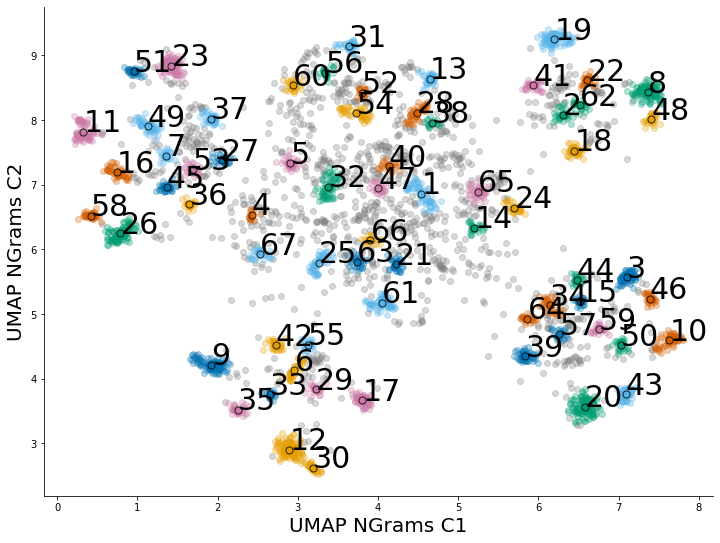

In [7]:
Center_ave = np.zeros([len(clusters),2])
fig,ax = plt.subplots()
fig.set_size_inches(12, 9)
for j,i in enumerate(clusters):
    row_ix = np.where(yhat == i)  # get row indexes for samples with this cluster
    if i != 0:
        # Plot the data
        plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha = 0.3, color=my_colorblind_colors_set[j])
        # Plot points that are at the center of each cluster, and annotate them with their autonomous number label
        Center_ave[i,0] = np.average(X[row_ix, 0])
        Center_ave[i,1] = np.average(X[row_ix, 1])
        plt.scatter(Center_ave[i,0], Center_ave[i,1], alpha=0.8, s=50, color=my_colorblind_colors_set[j],edgecolors='black')
        plt.annotate(i, (Center_ave[i,0], Center_ave[i,1]), fontsize = 30, alpha=1)
        
    if i == 0:
        plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha = 0.3, color='gray') # plot the noise points less intensely

#plt.title(cluster_out_title,fontsize=25)
plt.xlabel(C1_col_name,fontsize=20)
plt.ylabel(C2_col_name,fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.xlim(7.5,16.5)
plt.show()

fig.savefig(os.path.join(outputfile,f'{cluster_out_title} All.png'), dpi=120) # save the figure as an image

# Perform Weblogos on detected clusters

## Input from above

In [8]:
clusterfilein = os.path.join(outputfile,f'{cluster_out_title} All.csv')
#clusterfilein = os.path.join(outputfile,f'20220921 JUST NGrams12 UMAP Data eps 0.1511, sample_min 22, 60 clusters4-NG.csv')
print(f'Will analyze {clusterfilein}')
dfw = pd.read_csv(clusterfilein)

Will analyze C:\Users\josep\Documents\MIT\Machine Learning + Python\Binder Finder\20230325 - Seeing if Logomaker can be fixed\Outputs\UMAP NGrams FixLM\UMAP NGrams FixLM eps 0.1022 sample_min 16 67 clusters All.csv


## Generate Logo plots, consensus sequences, and pick centroid sequences

In [9]:
# Uncomment for just the weblogos. Nice if you are just scouting the data
# if not Deconvolute_N_Grams:
#     clusters = np.unique(dfw['Cluster labels'])
#     for cluster in clusters: # iterate through each cluster
#         chosen_ones = dfw.loc[dfw['Cluster labels'] == cluster]
#         chosen_sequences = chosen_ones[chosen_ones.columns[0]].to_list()
#         methods.generate_logos(chosen_sequences,
#                           os.path.join(outputfile,f'Weblogo {save_title} Cluster {cluster} {len(chosen_sequences)} peps.png'),
#                           displaysavefilename_astitle=False)

Aligning sequences from cluster 0


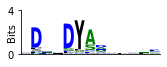

Cluster 0: No centroid will be reported for the noise cluster
Aligning sequences from cluster 1


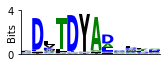

Cluster 1, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WDLYDDKTDYAA'
Aligning sequences from cluster 2


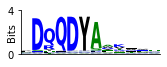

Cluster 2, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VMQFTDQQDYAW'
Aligning sequences from cluster 3


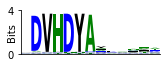

Cluster 3, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'DVHDYAYGYYHA'
Aligning sequences from cluster 4


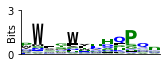

Cluster 4, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FYWNEMFWDHQP'
Aligning sequences from cluster 5


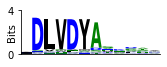

Cluster 5, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VSWDLVDYAWKF'
Aligning sequences from cluster 6


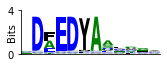

Cluster 6, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'MLRGDFEDYAAN'
Aligning sequences from cluster 7


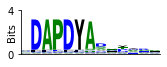

Cluster 7, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'SVEDDAPDYADF'
Aligning sequences from cluster 8


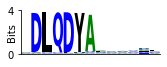

Cluster 8, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'HQFDKDLQDYAE'
Aligning sequences from cluster 9


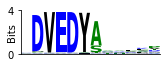

Cluster 9, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'GNFGGDVEDYAY'
Aligning sequences from cluster 10


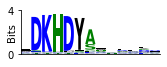

Cluster 10, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VTWVQDKHDYFS'
Aligning sequences from cluster 11


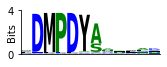

Cluster 11, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WFFTDMPDYANL'
Aligning sequences from cluster 12


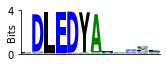

Cluster 12, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'GNMNLGDLEDYA'
Aligning sequences from cluster 13


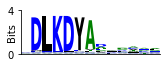

Cluster 13, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VQTFTDLKDYAW'
Aligning sequences from cluster 14


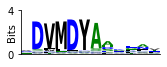

Cluster 14, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'LTDVMDYAAKEA'
Aligning sequences from cluster 15


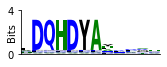

Cluster 15, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WWHDQHDYAHWT'
Aligning sequences from cluster 16


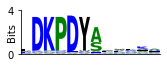

Cluster 16, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'YVKDKPDYAYKF'
Aligning sequences from cluster 17


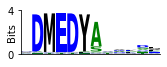

Cluster 17, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WFVHDMEDYAMR'
Aligning sequences from cluster 18


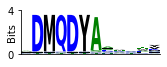

Cluster 18, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FDRDMQDYASML'
Aligning sequences from cluster 19


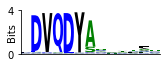

Cluster 19, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VPTDVQDYAHPR'
Aligning sequences from cluster 20


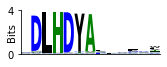

Cluster 20, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'EQFHHYDLHDYA'
Aligning sequences from cluster 21


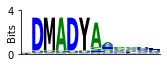

Cluster 21, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WDMADYAEADHL'
Aligning sequences from cluster 22


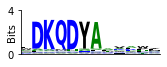

Cluster 22, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FRKWDKQDYAYP'
Aligning sequences from cluster 23


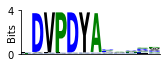

Cluster 23, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'HMTDVPDYAYHV'
Aligning sequences from cluster 24


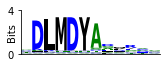

Cluster 24, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'YSNVDLMDYAEP'
Aligning sequences from cluster 25


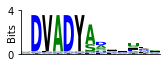

Cluster 25, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'TNFQHDVADYAG'
Aligning sequences from cluster 26


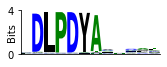

Cluster 26, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'EMWADLPDYAHA'
Aligning sequences from cluster 27


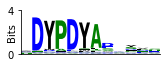

Cluster 27, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'LPVHWYDYPDSF'
Aligning sequences from cluster 28


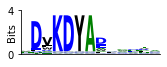

Cluster 28, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'SVDVKDYADEWN'
Aligning sequences from cluster 29


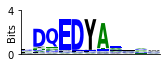

Cluster 29, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'YFEDQEDYAGWS'
Aligning sequences from cluster 30


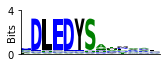

Cluster 30, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VSNTNYDLEDYS'
Aligning sequences from cluster 31


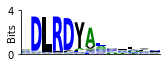

Cluster 31, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FAKGDLRDYAQK'
Aligning sequences from cluster 32


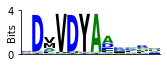

Cluster 32, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WNLDMVDYAAKF'
Aligning sequences from cluster 33


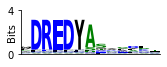

Cluster 33, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FLTQQDREDYAH'
Aligning sequences from cluster 34


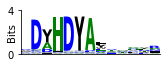

Cluster 34, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'PDYHDYAFARGL'
Aligning sequences from cluster 35


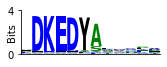

Cluster 35, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FQAFMDKEDYSF'
Aligning sequences from cluster 36


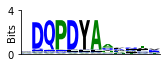

Cluster 36, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'YGMLDQPDYAAY'
Aligning sequences from cluster 37


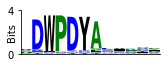

Cluster 37, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'QDWPDYAWGGPR'
Aligning sequences from cluster 38


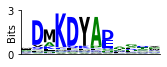

Cluster 38, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'AGFDKKDYADAF'
Aligning sequences from cluster 39


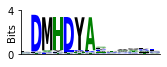

Cluster 39, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'KDMHDYASMHMW'
Aligning sequences from cluster 40


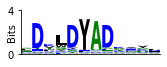

Cluster 40, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VNSYADTLDYAD'
Aligning sequences from cluster 41


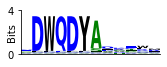

Cluster 41, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'LRWHNDWQDYAY'
Aligning sequences from cluster 42


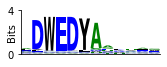

Cluster 42, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'AENEDWEDYAST'
Aligning sequences from cluster 43


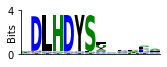

Cluster 43, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'RDLHDYSGPRSN'
Aligning sequences from cluster 44


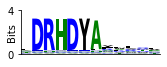

Cluster 44, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VSTADRHDYAYL'
Aligning sequences from cluster 45


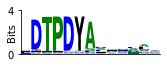

Cluster 45, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'YDMEDTPDYADM'
Aligning sequences from cluster 46


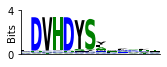

Cluster 46, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'TSVDVHDYSAHF'
Aligning sequences from cluster 47


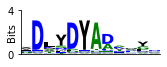

Cluster 47, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'ELAYYDTYDYAD'
Aligning sequences from cluster 48


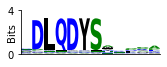

Cluster 48, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WLQDLQDYSHAP'
Aligning sequences from cluster 49


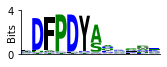

Cluster 49, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WWDFPDYANGRW'
Aligning sequences from cluster 50


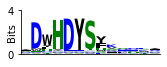

Cluster 50, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'HFNWYDWHDYSF'
Aligning sequences from cluster 51


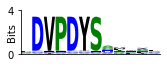

Cluster 51, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'YWEFQDVPDYSY'
Aligning sequences from cluster 52


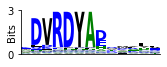

Cluster 52, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'DVRDYADDKYYE'
Aligning sequences from cluster 53


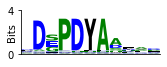

Cluster 53, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'MMMVDSPDYAAN'
Aligning sequences from cluster 54


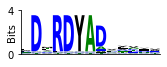

Cluster 54, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'MWLGDTRDYADT'
Aligning sequences from cluster 55


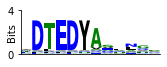

Cluster 55, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WWEATADTEDYA'
Aligning sequences from cluster 56


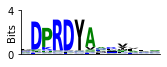

Cluster 56, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'MMTEDPRDYAFF'
Aligning sequences from cluster 57


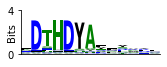

Cluster 57, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WDTHDYAAWSGT'
Aligning sequences from cluster 58


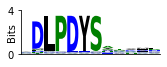

Cluster 58, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'DALSDLPDYSAS'
Aligning sequences from cluster 59


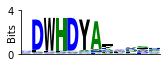

Cluster 59, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FDWHDYAEHVQS'
Aligning sequences from cluster 60


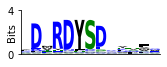

Cluster 60, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'MYRFDRRDYSDQ'
Aligning sequences from cluster 61


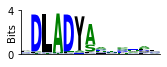

Cluster 61, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VGGWYDLADYAG'
Aligning sequences from cluster 62


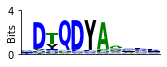

Cluster 62, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VVGGLDTQDYAH'
Aligning sequences from cluster 63


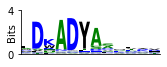

Cluster 63, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FSLADKADYAAQ'
Aligning sequences from cluster 64


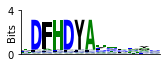

Cluster 64, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'FDFHDYAYNQGM'
Aligning sequences from cluster 65


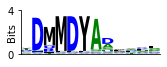

Cluster 65, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'NDMMDYADMDRL'
Aligning sequences from cluster 66


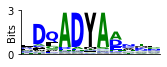

Cluster 66, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'VLWTFDQADYAE'
Aligning sequences from cluster 67


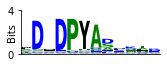

Cluster 67, Number of seqeuence(s) reported is 1; Centroid sequence(s): 'WMMPGDADPYAD'


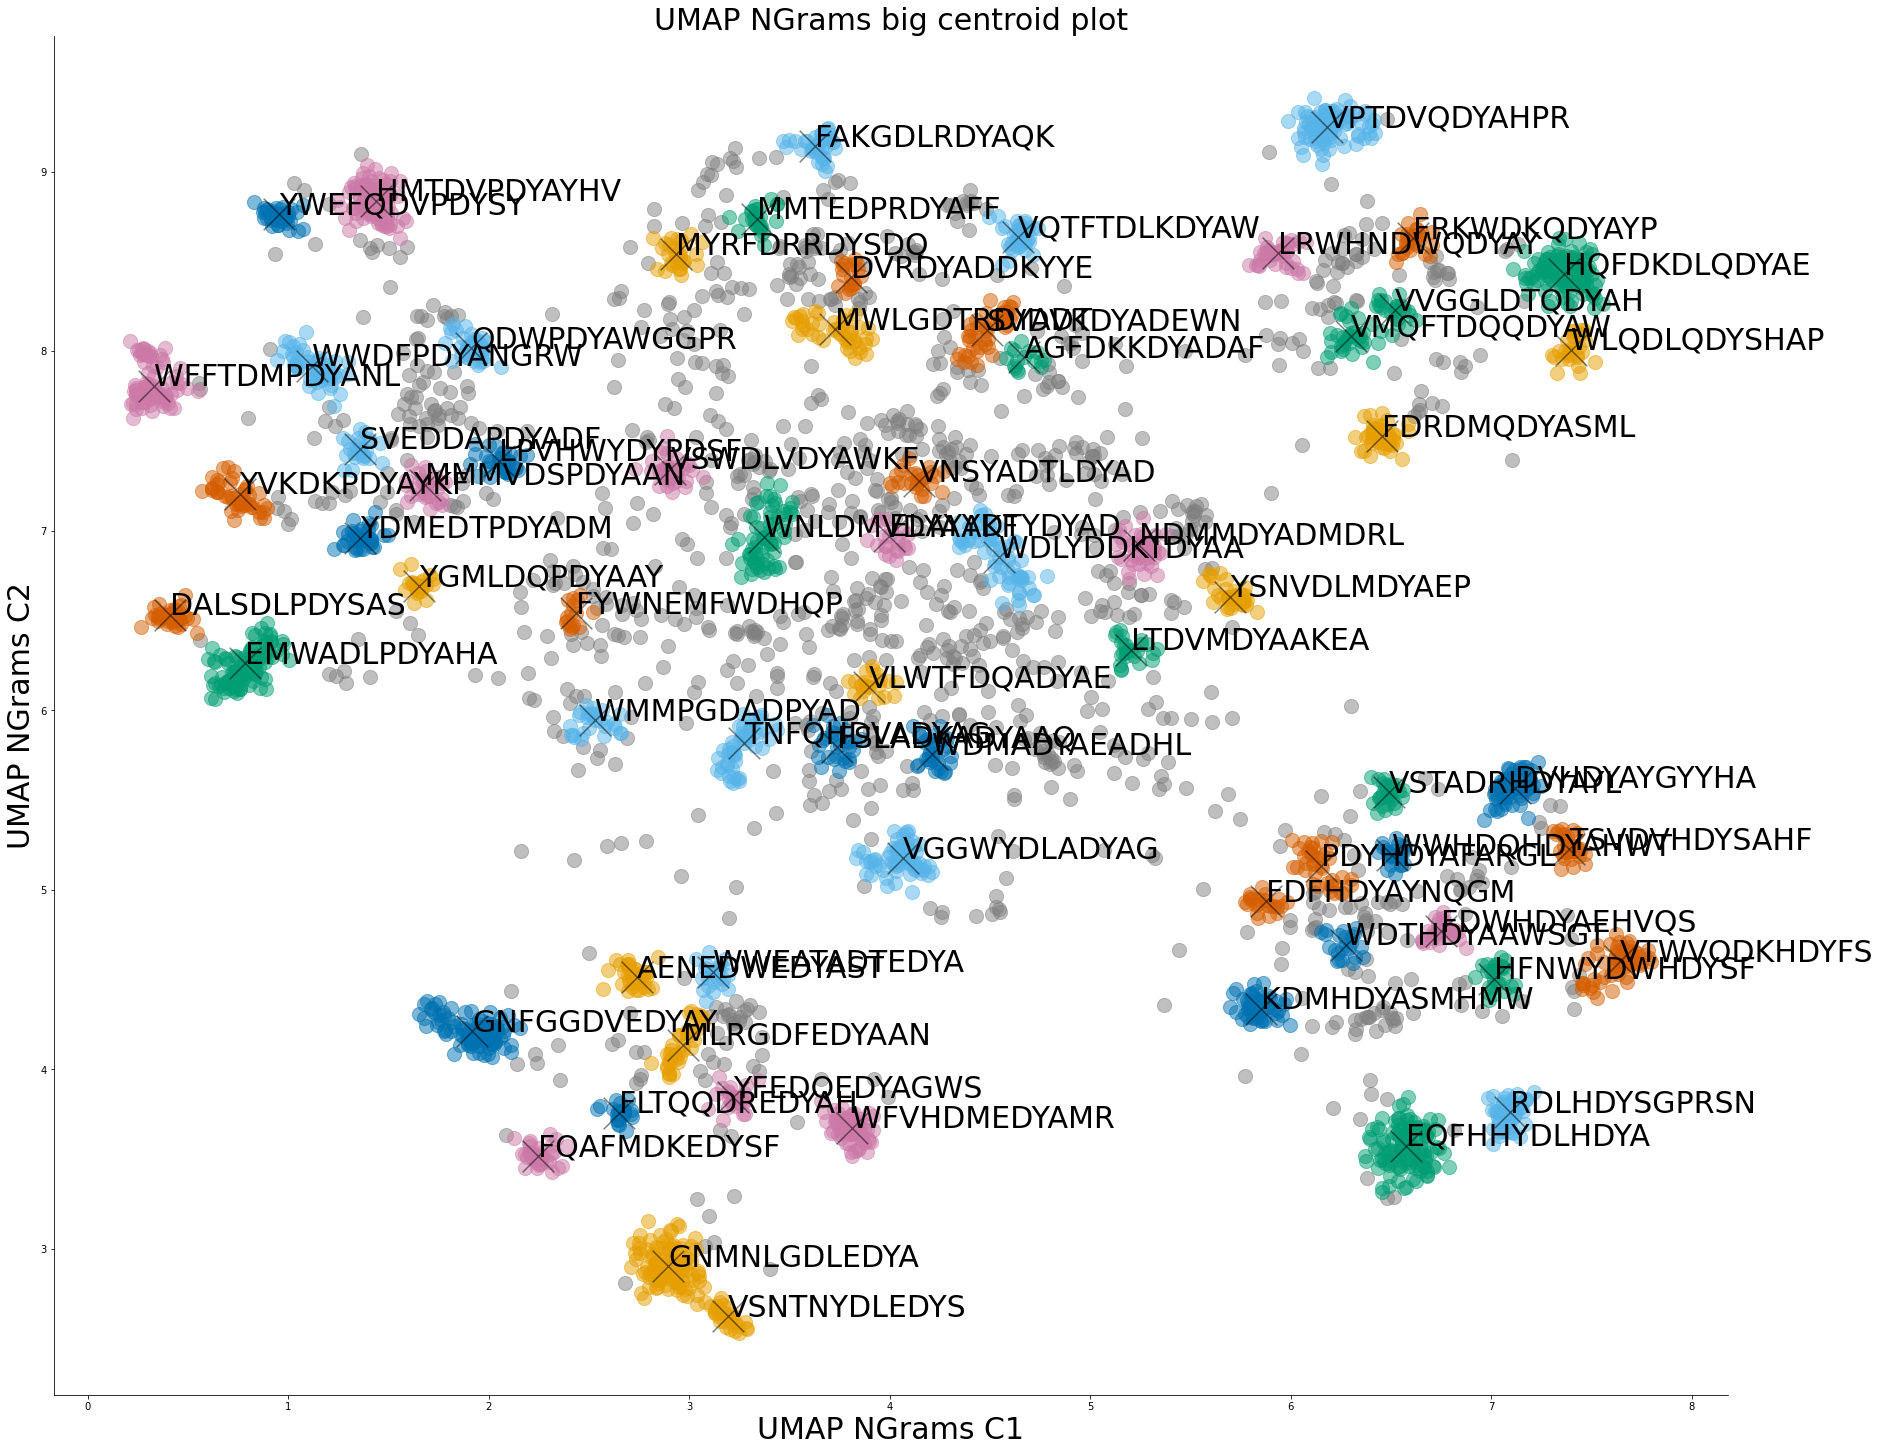

In [10]:
number_of_centroid_seqs_requested = 1

workbook = xlsxwriter.Workbook(outputfile + f'\{save_title} Detailed_Excel.xlsx')
worksheet = workbook.add_worksheet()

# Set up column titles in Excel, just formating sizes and labels
worksheet.write('A1', 'Auto-assigned cluster #') # write string
worksheet.write('B1', '# of peptides')
worksheet.write('C1', 'Centroid sequence')
worksheet.write('D1', 'Consensus sequence')
worksheet.write('E1', 'Sequence logo')
worksheet.write('F1', 'Motif class')
worksheet.write('G1', 'All sequences in cluster listed in row --->') # write string
worksheet.set_column('A:A', 13)
worksheet.set_column('B:B', 12)
worksheet.set_column('C:C', 17)
worksheet.set_column('D:D', 17)
worksheet.set_column('E:E', 35)
worksheet.set_row(0,30)

centroid_df = pd.DataFrame() # open a dataframe for saving the centroid sequences from each cluster

for cluster in clusters: # iterate through each cluster
    column_index = str(cluster+2) # column index just for Excel writing
    chosen_ones = dfw.loc[dfw['Cluster labels'] == cluster] # isolate data from each cluster
    chosen_sequences = chosen_ones['Peptide'].to_list() # grab just the sequences
    
    # Write column titles to Excel and minimum information about each cluster
    worksheet.write('A'+column_index, str(cluster)) # write the cluster number
    worksheet.write('B'+column_index, len(chosen_ones)) # write the number of peptides in each cluster
    worksheet.set_row(cluster+1,67) # make row height larger
    
    if not Deconvolute_N_Grams:
        # Generate logos as images (.png)
        methods.generate_logos(chosen_sequences,
                          os.path.join(outputfile,f'Weblogo {save_title} Cluster {cluster} {len(chosen_sequences)} peps.png'),
                          displaysavefilename_astitle=False)
        # Grab consensus sequence
        consensus_sequence_str = methods.consensus_seq(chosen_sequences,consensus_cutoff)
    
    if Deconvolute_N_Grams: # Deconvoluting the N_Grams encoding by alignment takes mulitple steps: First, alignment. Note that aligning the noise cluster may not make sense
        aligned_seqs = methods.aligner(chosen_sequences,cluster,outputfile)

        # Grab consensus sequence, use it to find where the alignment starts (i.e., not padded by '-' or weak 'X')
        consensus_cutoff = 0.7 # the data quality may benefit from increasing consensus_cutoff
        consensus_sequence_str = methods.consensus_seq(aligned_seqs,consensus_cutoff) # Get consensus
        for i,letter in enumerate(consensus_sequence_str): # find where the consensus starts
            if letter == '-' or letter == 'X': letter_index = i+1
            else: break

        # Knowing where the alignment starts, produce logo plot of the aligned sequence region
        sliceo_aligned_seqs = [seq[letter_index-1:letter_index+NGRAM_MAX] for seq in aligned_seqs] # take the start of consensus + NGRAM_MAX
        methods.generate_logos(sliceo_aligned_seqs,
                          os.path.join(outputfile,f'Weblogo {save_title} Cluster {cluster} {len(chosen_sequences)} peps.png'),
                          displaysavefilename_astitle=False)

    #Insert weblogo into Excel
    worksheet.insert_image(
        'E'+column_index,
        os.path.join(outputfile,f'Weblogo {save_title} Cluster {cluster} {len(chosen_sequences)} peps.png'),
        {'x_offset': 4, 'y_offset': 4})

    # Prepare and write centroid sequence
    if cluster == 0: print('Cluster 0: No centroid will be reported for the noise cluster')
    if cluster != 0:
        C1 = chosen_ones[C1_col_name].to_list()
        C2 = chosen_ones[C2_col_name].to_list()
        centroidstr,dfout = methods.centroider(
            chosen_sequences,C1,C2,
            number_of_centroid_seqs_requested,
            cluster,C1_col_name, C2_col_name,
            generateplot=False,
            savecentroidplot=True)

        # Centroid sequences
        worksheet.write('C'+column_index, centroidstr)    # Write to Excel
        centroid_df = pd.concat([centroid_df,dfout], axis=0)  # Save centroid sequences by concatenating the dataframes

    #  Write consensus sequence
    worksheet.write('D'+column_index, consensus_sequence_str)    # write centroid sequence to Excel

    # list all the sequences in the row with each cluster
    for j,seq in enumerate(chosen_sequences):
        column_name = xlsxwriter.utility.xl_col_to_name(j+6)
        worksheet.write(column_name+column_index,seq)

# After iterating through all clusters...
workbook.close()
centroid_df.to_csv(os.path.join(outputfile,f'{save_title} Centroid report.csv'), index=False) # Save centroid dataframe to CSV
# Prepare a large plot showing all centroid sequences
methods.large_centroid_seq_plot(centroid_df,
                                dfw,
                                C1_col_name,
                                C2_col_name,
                                os.path.join(outputfile,f'Weblogo {save_title} Cluster {cluster} big centroid plot.png'))

# Manual assignment of expanded, common, or weak motif for figure

In [ ]:
# Here one should input the autonomous number labels in the index position they would like to re-label them for the figure
# for example: common_motif_unlabeled = [12,3] 
# will result in autonomously labeled cluster 12 appearing as cluster 1
# and  autonomously labeled cluster 3 appearing as cluster 2

expanded_motif_clusters_labeled = [8,12,20,9,26]
expanded_motif_clusters_unlabeled = [11,17,61,3,32,10,1,49,39,18,43,25,54,28,37,16,58,13,35,5,41,65,31,34,45,2,6,51,42,24,46,27,59,21,22,60,63,48,53,30,44,50,56,67,14,29,40,7,15,33,55,62,64,36,47,57,66,52,19,23]
common_motif_unlabeled = []
weak_motif = [0,4,38]

In [ ]:
# create scatter plot for samples from each cluster
Center_ave = np.zeros([len(clusters),2])
fig, axs = plt.subplots(1,1,figsize=(12,10)) ## Change Weblogo size
annotatesize = 60

for j,i in enumerate(clusters):
    row_ix = np.where(yhat == i)  # get row indexes for samples with this cluster
    
#Expanded motif in a nice orange, annotated with cluster # label:
    if i in expanded_motif_clusters_labeled:
        plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha = 0.5, color=(0.835,0.369,0)) # create scatter of these samples
        Center_ave = np.zeros([len(clusters)+1,2])
        Center_ave[i,0] = np.average(X[row_ix, 0])
        Center_ave[i,1] = np.average(X[row_ix, 1])    
        plt.scatter(Center_ave[i,0], Center_ave[i,1], alpha=1, s=70, color=(0.835,0.369,0), edgecolors='black')        
        plt.annotate(str(expanded_motif_clusters_labeled.index(i)+1), (Center_ave[i,0]+0.02, Center_ave[i,1]+0.02), fontsize = annotatesize)

#Expanded motif in a nice orange, NOT annotated with cluster # label:
    if i in expanded_motif_clusters_unlabeled:
        plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha = 0.5, color=(0.835,0.369,0)) # create scatter of these samples
        Center_ave[i,0] = np.average(X[row_ix, 0])
        Center_ave[i,1] = np.average(X[row_ix, 1])   
        plt.scatter(Center_ave[i,0], Center_ave[i,1], alpha=1, s=70, color=(0.835,0.369,0), edgecolors='black')
        
# Common motif in blue, (0.337,0.706,0.914)
    if i in common_motif_unlabeled:
        plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha = 0.5, color=(0.337,0.706,0.914)) # create scatter of these samples
        Center_ave[i,0] = np.average(X[row_ix, 0])
        Center_ave[i,1] = np.average(X[row_ix, 1])
        plt.scatter(Center_ave[i,0], Center_ave[i,1], alpha=1, s=70, color=(0.337,0.706,0.914), edgecolors='black')

# Weak in gray
    if i in weak_motif and i != 0:
        plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha = 0.5, c='gray') # create scatter of these samples
        Center_ave[i,0] = np.average(X[row_ix, 0])
        Center_ave[i,1] = np.average(X[row_ix, 1])
        plt.scatter(Center_ave[i,0], Center_ave[i,1], alpha=1, s=70, color='gray',edgecolors='black')

# Noise points
    if i == 0:
        plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha = 0.5, c='gray') # create scatter of these samples
    
hfont = {'fontname':'Arial'}
plt.xlabel(f'{C1_col_name[:-3]}, Component 1', fontsize=35, **hfont, labelpad=10)
plt.ylabel(f'{C2_col_name[:-3]}, Component 2', fontsize=35, **hfont, labelpad=7)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_linewidth(4)
axs.spines['bottom'].set_linewidth(4)
axs.set_xticks([])
axs.set_yticks([])
#plt.title(cluster_out_title, fontsize=25, **hfont)
#plt.xlim(x,x)
#plt.ylim(x,x)
plt.show()

fig.savefig(os.path.join(outputfile,f'{cluster_out_title} All Highlighted Labeled.png'), dpi=120)